In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [3]:
# Download the file using wget
!wget -q -O read_wandb.py https://raw.githubusercontent.com/eilamshapira/HumanChoicePrediction/master/RunningScripts/read_wandb.py


In [4]:
from read_wandb import wandb_results
api = wandb_results("Strategy_Transfer_TACL", wandb_username="rwanbd")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
def result_metric(sweeps, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric)
    np.set_printoptions(precision=3)
    acc = df["ENV_Test_accuracy_per_mean_user_and_bot_epoch15"]
    df_cols = {'mean': acc.mean(), 'std': acc.std(), 'values': acc.values}
    df_cols['CI'] = bootstrap_ci(acc)
    return df_cols

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [6]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

sweep_results = result_metric(["2ntppkod"], drop_HPT=False, epoch="best")
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)     # Don't truncate output width
pd.set_option('display.max_colwidth', None)
display(sweep_results)

Total number of sweeps: 1
Download sweep_id='2ntppkod' data...


100%|██████████| 46/46 [00:01<00:00, 43.10it/s]


{'mean': 0.8388364382507787,
 'std': 0.0025062086098381143,
 'values': array([0.838, 0.838, 0.836, 0.844, 0.836, 0.838, 0.837, 0.837, 0.837,
        0.842, 0.842, 0.838, 0.838, 0.843, 0.834, 0.843, 0.838, 0.836,
        0.84 , 0.842, 0.836, 0.839, 0.837, 0.845, 0.838, 0.839, 0.842,
        0.839, 0.838, 0.841, 0.84 , 0.84 , 0.836, 0.837, 0.84 , 0.839,
        0.836, 0.836, 0.838, 0.838, 0.841, 0.836, 0.842, 0.838, 0.837,
        0.842]),
 'CI': (0.8381343031685686, 0.839561766226435)}

# Graphs

wandb: Currently logged in as: rwanbad (rwanbd). Use `wandb login --relogin` to force relogin


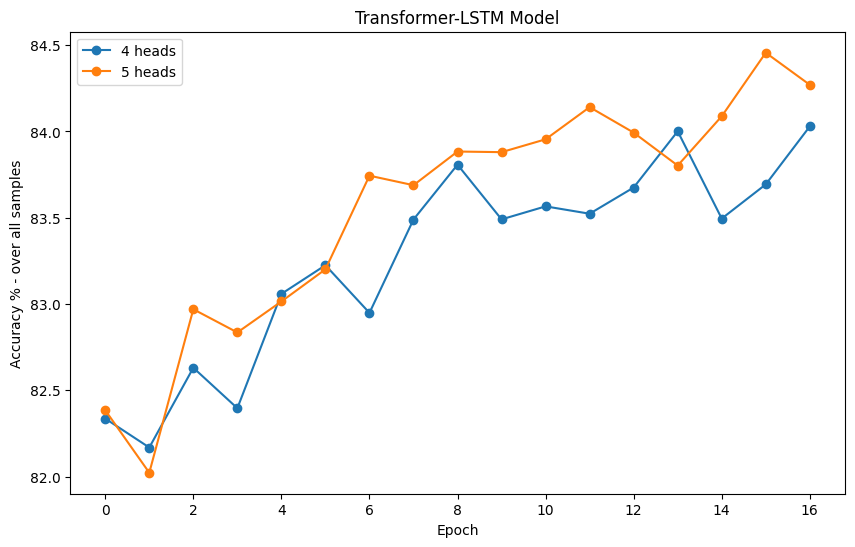

In [7]:
import wandb
import matplotlib.pyplot as plt
# from read_wandb import wandb_results
# Initialize wandb
wandb.login()


# Initialize a dictionary to hold the data
data = {}

# Access the API and fetch the runs from the specific sweep
api = wandb.Api()
run_ids = ['5t7xcphg','pbd1vwkr']
run_names = {'5t7xcphg': '4 heads', 'pbd1vwkr': '5 heads'}  # Mapping of run IDs to new names for the legend

for id in run_ids:
    run = api.run(f"{'rwanbd'}/{'Strategy_Transfer_TACL'}/{id}")
    history = run.history()
    epochs = [i for i in range(0,25)]
    # Initialize list to hold accuracies for each epoch
    accuracies = []
    # Extract accuracies for each epoch dynamically
    for i in range(25):
        key = f'ENV_Test_accuracy_per_mean_user_and_bot_epoch{i}'
        if key in history.columns:
            accuracies.append(history[key][50]*100)  # Assuming at least one entry per epoch
        else:
           accuracies.append(None)
    # Store the data in the dictionary
    data[id] = (epochs, accuracies)



# Plotting
plt.figure(figsize=(10, 6))
for run_id in data.keys():
    plt.plot(data[run_id][0], data[run_id][1], label=f'{run_names[run_id]}', marker='o')  # Added marker here

plt.xlabel('Epoch')
plt.ylabel('Accuracy % - over all samples')
plt.title('Transformer-LSTM Model')
plt.legend()
# Set the background to white and remove grid
plt.gca().set_facecolor('white')
plt.grid(False)  # Turn off the grid
plt.show()

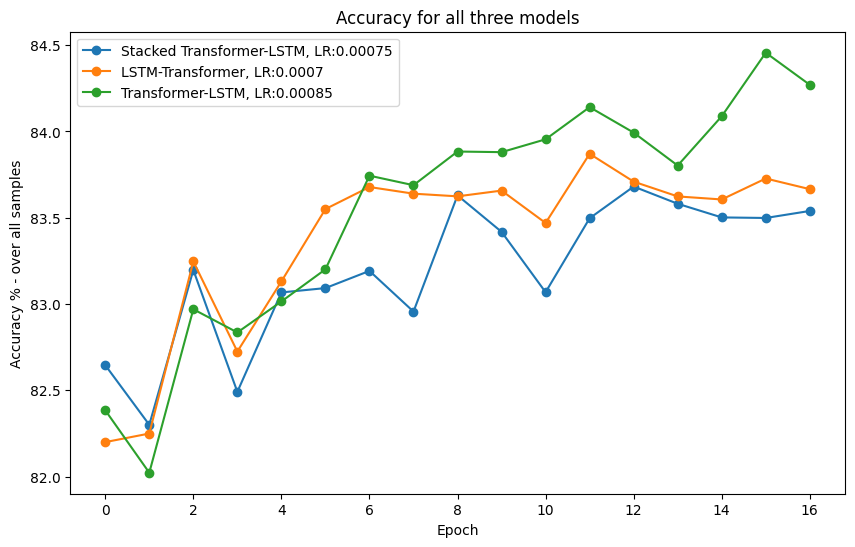

In [8]:
import wandb
import matplotlib.pyplot as plt
# from read_wandb import wandb_results
# Initialize wandb
wandb.login()


# Initialize a dictionary to hold the data
data = {}

# Access the API and fetch the runs from the specific sweep
api = wandb.Api()
run_ids = ['nkbegm1q','fltuvnos','pbd1vwkr']
run_names = {'nkbegm1q': 'Stacked Transformer-LSTM, LR:0.00075', 'fltuvnos': 'LSTM-Transformer, LR:0.0007','pbd1vwkr':'Transformer-LSTM, LR:0.00085'}  # Mapping of run IDs to new names for the legend

for id in run_ids:
    run = api.run(f"{'rwanbd'}/{'Strategy_Transfer_TACL'}/{id}")
    history = run.history()
    epochs = [i for i in range(0,25)]
    # Initialize list to hold accuracies for each epoch
    accuracies = []
    # Extract accuracies for each epoch dynamically
    for i in range(25):
        key = f'ENV_Test_accuracy_per_mean_user_and_bot_epoch{i}'
        if key in history.columns:
            accuracies.append(history[key][50]*100)  # Assuming at least one entry per epoch
        else:
           accuracies.append(None)
    # Store the data in the dictionary
    data[id] = (epochs, accuracies)



# Plotting
plt.figure(figsize=(10, 6))
for run_id in data.keys():
    plt.plot(data[run_id][0], data[run_id][1], label=f'{run_names[run_id]}', marker='o')  # Added marker here

plt.xlabel('Epoch')
plt.ylabel('Accuracy % - over all samples')
plt.title('Accuracy for all three models')
plt.legend()
# Set the background to white and remove grid
plt.gca().set_facecolor('white')
plt.grid(False)  # Turn off the grid
plt.show()